# Preprocessing of adata objects

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import h5py
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from osn.nmf import apply_nmf
from osn.olfr import olfr
from osn.preprocess import get_data_folders

In [3]:
sns.set_context("talk")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load home-cage adata 

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "home_cage_norm.h5ad"
adata = sc.read(ad_fn)
print(adata)

AnnData object with n_obs × n_vars = 38345 × 30681
    obs: 'top_Olfr', 'source', 'orig_ident', 'ES_score', 'UMAP_1', 'UMAP_2', 'round2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts', 'OR_counts', 'OR_counts_norm'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf', 'X_umap'


# Look at the OR expressed in each OSN
We used the OR genes that were annotated to be functional (i.e. not pseudogenes). These were the genes with GO term "olfactory receptor activity" (GO:0004984); the TAAR family of receptors was also included (GO:0001594, GO:1990081).

The function `olfr.get_OR_info(adata)` looks for which ORs are singly-expressed in each cell (based on the raw UMI counts).

In [5]:
func_OR = olfr.load_func_OR()
display(func_OR.head())

,ensembl_gene_id,mgi_symbol,mgi_description,chromosome_name,start_position,end_position,TSS_diff,cluster_3Mb_bychr,OR_class
external_gene_name,,,,,,,,,
Olfr1416,ENSMUSG00000067064,Olfr1416,olfactory receptor 1416,1,92475925,92485113,0,01-1,class2
Olfr1415,ENSMUSG00000057464,Olfr1415,olfactory receptor 1415,1,92489101,92496101,13176,01-1,class2
Olfr1414,ENSMUSG00000042849,Olfr1414,olfactory receptor 1414,1,92506366,92518661,17265,01-1,class2
Olfr1413,ENSMUSG00000058904,Olfr1413,olfactory receptor 1413,1,92571322,92574397,64956,01-1,class2
Olfr1412,ENSMUSG00000046300,Olfr1412,olfactory receptor 1412,1,92585779,92591375,14457,01-1,class2


In [6]:
# find which cells express Olfrs
df_OR, has_OR = olfr.get_OR_info(adata)
display(df_OR.head())
# confirm that extracted ORs matches those saved in metadata
assert (df_OR.top_Olfr == adata.obs.top_Olfr).all()

,top_Olfr,orig_ident,source,OR_counts,OR_counts_norm,OR_class,cluster_3Mb_bychr,Dorsal,Ventral,Anterior,Posterior,Cd36,High,Low,ES_score
baseline-1_AAACCCAGTAGTGTGG,Olfr228,baseline-1,baseline-cage,100.0,104.079933,class2,02-2,61.819379,33.755248,0.000000,60.767606,0.000000,0.000000,113.739399,-113.739399
baseline-1_AAACCCATCTAAGGAA,Olfr111,baseline-1,baseline-cage,26.0,22.606731,class2,17-2,135.374186,0.000000,0.000000,106.774866,20.374480,0.000000,308.587823,-308.587823
baseline-1_AAACGAAAGCTGAGTG,Olfr984,baseline-1,baseline-cage,26.0,29.731274,class2,09-2,10.134398,159.579356,8.923343,8.910267,0.000000,64.808465,43.665520,21.142945
baseline-1_AAACGAACAAGAGGTC,Olfr786,baseline-1,baseline-cage,25.0,25.204155,class2,10-3,0.000000,27.315977,131.728949,9.418199,343.050271,63.964069,0.000000,63.964069
baseline-1_AAACGAAGTAGAATAC,Olfr1330,baseline-1,baseline-cage,87.0,74.213089,class2,04-4,17.769529,0.000000,220.656676,40.515654,79.753526,284.527477,0.000000,284.527477


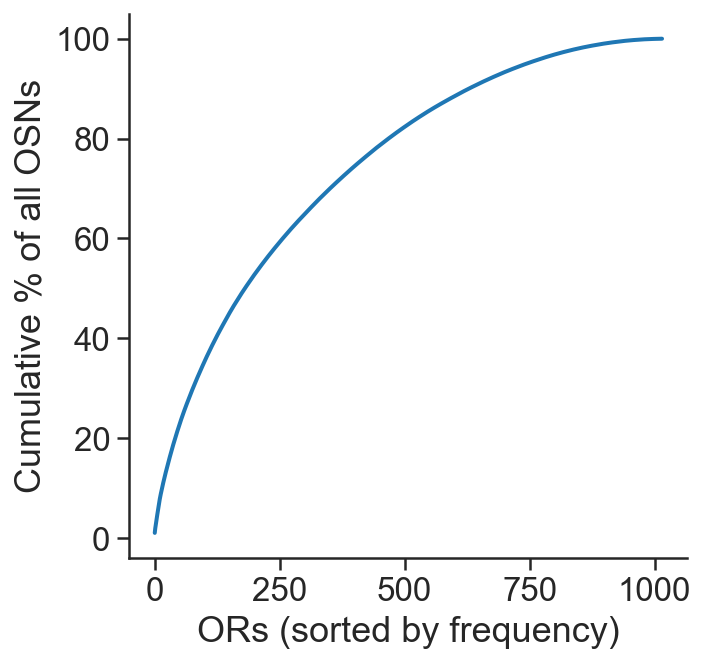

In [7]:
y = df_OR.top_Olfr.value_counts().values
y = y / y.sum() * 100
x = np.arange(len(y))

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, np.cumsum(y), lw=2)
ax.set_xlabel("ORs (sorted by frequency)")
ax.set_ylabel("Cumulative % of all OSNs")
sns.despine()

# apply cNMF 
* using fitting gene loadings (see [Table S2](../data/tables/GSE173947_Table_S2_nmf_loadings.csv)) for a set of 1350 highly-variable genes to get NMF usages for each cNMF factor for each cell

In [8]:
h5_files = list(data_fold.processed.rglob("*_norm.h5ad"))
for fn in h5_files:
    with h5py.File(fn, "r") as f:
        refit = 'obsm/X_nmf' not in f
    if refit:
        print(f"Getting NMF usages for {fn.name}")
        this_adata = sc.read(fn)
        df_nmf = apply_nmf(this_adata)
        this_adata.obsm['X_nmf'] = df_nmf
        this_adata.write_h5ad(fn)
        print(f"Updated {fn.name} file with usages")
    else:
        print(f"Already found usages in `obsm/X_nmf` for {fn.name}")

Already found usages in `obsm/X_nmf` for ChronicOccl_norm.h5ad
Already found usages in `obsm/X_nmf` for ActSeq_norm.h5ad
Already found usages in `obsm/X_nmf` for ActSeq_conc_analog_norm.h5ad
Already found usages in `obsm/X_nmf` for env_switch_norm.h5ad
Already found usages in `obsm/X_nmf` for home_cage_norm.h5ad
